## Functions

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re

from sklearn.metrics import mean_squared_error, mean_absolute_error


def plotAllRMSEs (inferences, colors, 
                   models_to_plot=[], average_rmses=True, plot_rmses_for_av_pred=True,
                  limits=(4e-4, 1e-2), figname='') :
    plotElementRMSEs(inferences, colors, models_to_plot=models_to_plot,
                     average_rmses=average_rmses, plot_rmses_for_av_pred=plot_rmses_for_av_pred, 
                     limits=limits, figname=figname)
    
def plotElementRMSEs(inferences, colors, 
                     models_to_plot=[], average_rmses=True, plot_rmses_for_av_pred = True,
                     limits=(2e-4, 1e-2), figname='') :
    fig, axs = plt.subplots(1, 2, sharey=True, figsize=(7,3))
    axs[0].set_ylabel('RMSE, meV/atom')
    for i in range(2):
        axs[i].grid(alpha=0.3)
    if len(models_to_plot) == 0:
        models_to_plot = inferences.keys()
    for model in models_to_plot :
        data = inferences[model]
        color = colors[model]
        test_data = data[data['inWhichPart'] == 'test'].copy()

        for i, dopant in enumerate(sorted(data['dopant'].unique())) :
            test_data_subsample = test_data[(test_data['dopant'] == dopant)]
            axs[i].set_title(f'{dopant}-doping') #: {Z} f.u. per cell

            if not average_rmses :
                axs[i].plot(range(48), 1000*np.array([mean_squared_error(
                                            y_true=test_data_subsample['formation_energy_pa_DFT'], 
                                            y_pred=test_data_subsample[f'val_{k}'],
                                            squared=False) for k in range(48)]), '.-', 
                             c=color,
                             label=f'{models_labels[model]}')
                axs[i].set_xlabel('Validation')

            if average_rmses :
                to_plot = 1000*np.array([mean_squared_error(
                                            y_true=test_data_subsample['formation_energy_pa_DFT'], 
                                            y_pred=test_data_subsample[f'val_{k}'],
                                            squared=False) for k in range(48)])
                to_plot = to_plot.reshape(-1, 12, )
                to_plot_mean = np.mean(to_plot, axis=0)
                to_plot_std = np.std(to_plot, axis=0)
                axs[i].plot(range(12), to_plot_mean, label=f'{models_labels[model]}', c=color, lw=1)
                axs[i].fill_between(range(12), to_plot_mean - to_plot_std, to_plot_mean + to_plot_std, 
                                      alpha=0.2, color=color)
                for subgroup_id in range(to_plot.shape[0]) :
                    axs[i].scatter(range(12), to_plot[subgroup_id], alpha=0.7, c=color, s=7)
                if plot_rmses_for_av_pred :
                    axs[i].plot(range(12), 1000* np.array([mean_squared_error(
                                            y_true=test_data_subsample['formation_energy_pa_DFT'], 
                                            y_pred=test_data_subsample[[f'val_{l}' 
                                            for l in (12*np.arange(to_plot.shape[0]) + k)]]\
                                                                .mean(axis=1),
                                            squared=False) for k in range(12)]), '--', c=color,
                              label=f'Av.preds.\n{model}')
                axs[i].set_xlabel('Validation group id')
                axs[i].set_xticks(range(12))
            
            axs[i].set_ylim(limits)
            axs[i].set_yscale('log')

    plt.tight_layout()
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Model')
    plt.show()
    return None


def deltaDFTEvaluation (data, energy_tag, mults=(1, 1e3)):
    df = data[['subst', 'phase', energy_tag]].groupby(['phase', 'subst']).min()
    df = df.reset_index(level=0)
    df = df.pivot_table(values=energy_tag, index=df.index, columns='phase')
    return (df.index * mults[0], (df['black'] - df['yellow']) * mults[1])

def BoltzmannAverage(values, energies, weights, Boltzmann_kT=0.0257): 
    values = values.values; energies = energies.values ; weights = weights.values
    energy_increments = energies - energies.min()
    Z = weights * np.exp(-energy_increments / Boltzmann_kT) 
    return np.sum(values * Z) / np.sum(Z)

def getFormationEnergy(data, dopant, phase, subst, validation_type=0, group=True, Boltzmann_kT=0) :
    subset = data[(data['dopant']==dopant) & (data['phase']==phase) & (data['subst']==subst)]
    weights = subset['weight']
    if group:
        df = subset[[f'val_{12*k + validation_type}' for k in range(4)]].copy()
    else :
        df = subset[[f'val_{validation_type}']].copy()
    df['mean'] = df.iloc[:,:4].mean(axis=1)
    df['std'] = df.iloc[:,:4].std(axis=1)
    if Boltzmann_kT == 0 :
        #boltzmann average is switched off 
        array = df[['mean', 'std']].values
        where_min = np.argmin(array[:,0])
        return array[where_min]
    else :
        #boltzmann average is switched on
        assert Boltzmann_kT > 0
        #df['delta_energy'] = df['mean'] - df['mean'].min()
        if group:
            array = np.array([BoltzmannAverage(df.iloc[:,index], df.iloc[:,index], 
                                        weights, Boltzmann_kT=Boltzmann_kT)
                                        for index in range(4)])
            return [np.mean(array), np.std(array)]
        else :
            return [BoltzmannAverage(df['mean'], df['mean'], weights, Boltzmann_kT=Boltzmann_kT), 0]

def getDeltaEnergy(data, dopant, substs, validation_type=0, group=True, Boltzmann_kT=0, mults=(1, 1e3)) :
        mean = [getFormationEnergy(data, dopant, 'black', subst, validation_type=validation_type,
                                                  group=group, Boltzmann_kT=Boltzmann_kT)[0] - \
                   getFormationEnergy(data, dopant, 'yellow', subst, validation_type=validation_type, 
                                                  group=group, Boltzmann_kT=Boltzmann_kT)[0] 
                  for subst in substs]
#         if Boltzmann_kT != 0 :
#             return (np.array(substs)*mults[0], np.array(mean)*mults[1])
#         else :
        std = [getFormationEnergy(data, dopant, 'black', subst, validation_type=validation_type,
                                                  group=group, Boltzmann_kT=Boltzmann_kT)[1] + \
                   getFormationEnergy(data, dopant, 'yellow', subst, validation_type=validation_type,
                                                  group=group, Boltzmann_kT=Boltzmann_kT)[1]
                    for subst in substs]
        return (np.array(substs)*mults[0], np.array(mean)*mults[1], np.array(std)*mults[1])

## Inference loading

| ordinal number | column tag | content description |
| --- | --- | --- |
|1| phase | yellow/black (corresponds to the phase studied) |
|2| supercell | the supercells used (depends on phase) |
|3| subst | the number of substituted Pb positions |
|4| index | structure id (unique within a certain composition) |
|5| weight | corresponds to the number of symmetrically equivalent structures within combinatorial composition/configuration space |
|6| dopant | Cd/Zn (dopant type in the structure) |
|7| space_group_number | space symmetry of the doped structure before relaxation |
|8| formula | chemical formula (OrderedDict type) |
|9| natoms | 160 (the number of atoms in the model cells - constant feature) |
|10| atomic_numbers | atomic numbers of the structure |
|11| nelements | the number of chemical elements in the structure |
|12| cell | model cell sizes (before relaxation - constant feature for a certain phase) |
|13| pos | atomic positions (before relaxation) |
|14-61| val_i | GNN-predicted formation energy per atom (in eV/atom) for the $i^{th}$ validation subset |
|62| relaxed_cell_DFT | model cell sizes after DFT relaxation |
|63| relaxed_pos_DFT | DFT-relaxed atomic positions |
|64| relaxed_pressure_DFT | pressure (in kbar) for the DFT-relaxed structure |
|65| relaxed_forces_DFT | atomic forces (in eV/angstrom) for the DFT-relaxed structure |
|66| relaxed_energy_DFT | relaxed energy per cell (in eV) for the DFT-relaxed structure |
|67| relaxed_energy_pa_DFT | relaxed energy per atom (in eV/atom) for the DFT-relaxed structure |
|68| formation_energy_pa_DFT | formation energy per atom (in eV/atom) for the DFT-relaxed structure |
|69-116| val_i_DFT | boolean flag showing whether the configuration is in the $i^{th}$ validation subset |
|117| inWhichPart | tr_val, test, or inference (corresponds to the data usage within the approach proposed)|

In [2]:
%%time
models = ['both_both_schnet_non-pr', 'element_both_schnet_non-pr',
          'both_both_allegro_non-pr', 'element_both_allegro_non-pr',
          'both_both_allegro_ocpr', 'element_both_allegro_ocpr',
          'both_both_allegro_aflowpr', 'element_both_allegro_aflowpr'
         ]
inferences = dict(zip(models, [pd.read_pickle(f'data/nn inference/{model}.pkl.gz') for model in models]))

CPU times: user 8.38 s, sys: 1.48 s, total: 9.86 s
Wall time: 9.88 s


In [3]:
colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'black', 'orange', 'yellow']
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = list(prop_cycle.by_key()['color'])
colors = dict(zip(models, colors[:len(models)]))

In [4]:
models_labels = dict(zip(models, ['SchNet (both-both)', 'SchNet (element-both)',
                                  'Allegro (both-both)', 'Allegro (element-both)',
                                  'Allegro (both-both)\npre-trained on OC', 
                                  'Allegro (element-both)\npre-trained on OC',
                                  'Allegro (both-both)\npre-trained on Aflow', 
                                  'Allegro (element-both)\npre-trained on Aflow',
                                ]))

In [5]:
colors

{'both_both_schnet_non-pr': '#1f77b4',
 'element_both_schnet_non-pr': '#ff7f0e',
 'both_both_allegro_non-pr': '#2ca02c',
 'element_both_allegro_non-pr': '#d62728',
 'both_both_allegro_ocpr': '#9467bd',
 'element_both_allegro_ocpr': '#8c564b',
 'both_both_allegro_aflowpr': '#e377c2',
 'element_both_allegro_aflowpr': '#7f7f7f'}

In [6]:
model = 'both_both_allegro_non-pr'
inferences[model].describe()

,subst,index,weight,space_group_number,natoms,nelements,val_0,val_1,val_2,val_3,...,val_42,val_43,val_44,val_45,val_46,val_47,relaxed_pressure_DFT,relaxed_energy_DFT,relaxed_energy_pa_DFT,formation_energy_pa_DFT
count,73962.000000,73962.000000,73962.000000,73962.000000,73962.0,73962.000000,73962.000000,73962.000000,73962.000000,73962.000000,...,73962.000000,73962.000000,73962.000000,73962.000000,73962.000000,73962.000000,202.000000,202.000000,202.000000,202.000000
mean,5.738893,5998.000352,62.140937,1.168357,160.0,3.999946,-1.022048,-1.022387,-1.022455,-1.022123,...,-1.022919,-1.022656,-1.022345,-1.023836,-1.021840,-1.021295,0.042839,-445.135040,-2.782094,-1.028863
std,0.550053,4459.604011,7.720653,0.979444,0.0,0.007354,0.008079,0.007884,0.007958,0.007789,...,0.007799,0.007505,0.007969,0.007397,0.007499,0.007729,0.053740,3.365034,0.021031,0.007623
min,0.000000,0.000000,1.000000,1.000000,160.0,3.000000,-1.042772,-1.042555,-1.042881,-1.043241,...,-1.042739,-1.043305,-1.043034,-1.041739,-1.043097,-1.043521,-0.149584,-455.275068,-2.845469,-1.044134
25%,6.000000,1941.000000,64.000000,1.000000,160.0,4.000000,-1.031940,-1.032396,-1.032109,-1.031414,...,-1.032158,-1.031627,-1.032047,-1.033928,-1.031828,-1.030891,0.014462,-446.915874,-2.793224,-1.035750
50%,6.000000,5281.000000,64.000000,1.000000,160.0,4.000000,-1.022594,-1.022474,-1.022274,-1.022217,...,-1.022728,-1.022218,-1.022788,-1.024862,-1.022035,-1.021880,0.042025,-445.656899,-2.785356,-1.027606
75%,6.000000,9903.000000,64.000000,1.000000,160.0,4.000000,-1.017629,-1.018682,-1.018334,-1.017979,...,-1.018533,-1.019414,-1.017823,-1.020961,-1.019296,-1.018181,0.075116,-443.483413,-2.771771,-1.023089
max,6.000000,14543.000000,64.000000,62.000000,160.0,4.000000,-1.009889,-1.009958,-1.009833,-1.009827,...,-1.010631,-1.010705,-1.009603,-1.013448,-1.011034,-1.009301,0.176171,-436.943010,-2.730894,-1.012817


In [7]:
data = inferences['both_both_allegro_non-pr']
print(data.shape)
data_with_DFT = data[data['inWhichPart'] != 'inference']
print(data_with_DFT.shape)

(73962, 117)
(202, 117)


### Validation table from the manuscript

In [8]:
val_table = data[data['inWhichPart'] == 'tr_val'][['subst', *[f'val_{i}_DFT' for i in range(48)]]]\
        .groupby('subst').sum()/4
pd.DataFrame(val_table.T.values[:12], index=range(12), columns=[f'subst={s}' for s in range(4)], dtype=int)

,subst=0,subst=1,subst=2,subst=3
0,1,0,7,0
1,1,0,0,7
2,1,0,4,3
3,0,1,7,0
4,0,1,0,7
5,0,1,3,4
6,1,1,6,0
7,1,1,0,6
8,1,1,3,3
9,0,0,8,0


## Visualisation

### Formation energy distributions for the systems with N sustitutions

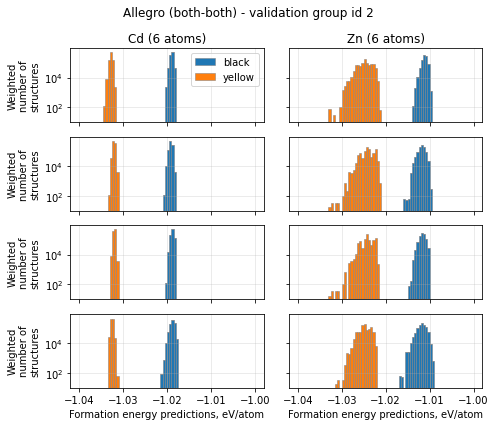

In [9]:
## Using the code below, one can plot distibutions of the GNN-predicted formation energies
## optionally changing validation_group in the range from 0 to 11
## and number of substituted positions subst in the range from 0 to 6
    
validation_group = 2 ; subst = 6

val_subsets = [f'val_{validation_group+i*12}' for i in range(4)]
phases = sorted(data['phase'].unique())

fig, axs = plt.subplots(len(val_subsets), len(phases), sharex=True, sharey=True, 
                        figsize=(7,1.5*len(val_subsets)))

for i, val_sub in enumerate(val_subsets):

    for j, dopant in enumerate(sorted(data['dopant'].unique())) :

        res = data[(data['dopant'] == dopant) & (data['subst'] == subst)]

        axs[i,j].hist(
            [res[res['phase'] == phase][val_sub] for phase in phases],
             weights=[res[res['phase'] == phase]['weight'] for phase in phases],
             edgecolor='grey', lw=0.5, stacked=True, bins=np.linspace(-1.04, -1.00, 81),
             label=sorted(data['phase'].unique()),
        )

        axs[i,j].grid(alpha=0.3)
        axs[i,j].set_yscale('log')
        if i == 0 :
            axs[0,j].set_title(f'{dopant} ({subst} atoms)')
        if j ==   0 :
            axs[i,0].set_ylabel('Weighted\nnumber of\nstructures')
        axs[-1, j].set_xlabel('Formation energy predictions, eV/atom')
axs[0,0].legend()

m = re.sub('\n', ' ', models_labels[model])
plt.suptitle(f'{m} - validation group id {validation_group}', y=0.98)    
plt.tight_layout()
plt.show()

### RMSEs

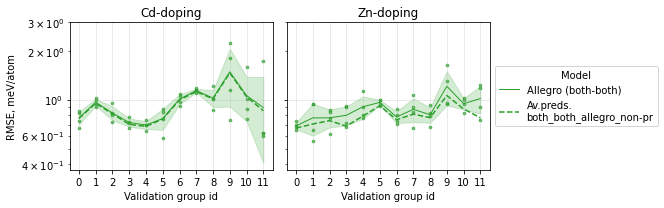

In [10]:
## Using the code below, one can plot the obtained test RMSE scores for the GNN-predicted formation energies
## optionally changing averaging mode (whether to average the RMSE value over the validation group or not)
## through average_rmses=True/False.
## For average_rmses == True, the RMSEs corresponding to the averaged (over validation groups) predictions
## are also available (plot_rmses_for_av_pred=True)

plotAllRMSEs(inferences, colors,
          models_to_plot=[
                         'both_both_allegro_non-pr',
                         ], 
          average_rmses=True,
          plot_rmses_for_av_pred=True,
          limits=(3.7e-1, 0.3e1),
         )

### Predicted energy differences between phases

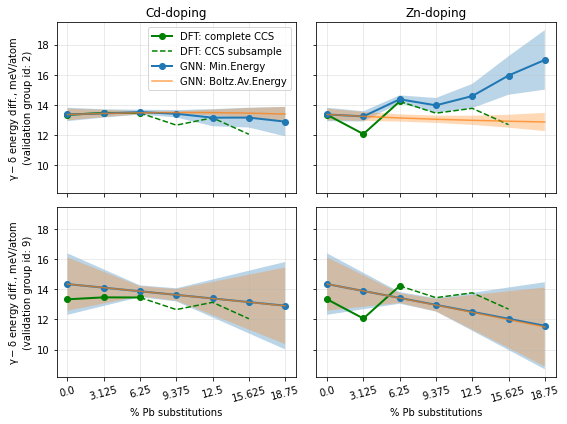

In [11]:
## Using the code below, one can plot the obtained energy differences between phases
## according to the GNN-predicted formation energies
## val_list correspond to the validation groups of interest [2,9] as in the manuscript

val_list = [2,9]


fig, axs = plt.subplots(len(val_list), 2, sharey=True, sharex=True, figsize=(8,3*len(val_list)))

for i, val in enumerate(val_list) : # range(12): # 
    for j, dopant in enumerate(sorted(data['dopant'].unique())) :

        axs[0,j].set_title(f'{dopant}-doping') #: {Z} f.u. per cell
        
        #delta between dft-derived values
        axs[i,j].plot(*deltaDFTEvaluation(data[(data['subst'] < 3) & (data['dopant'] == dopant)], 
                                        'formation_energy_pa_DFT'), 
                                        'o-', c='g', lw=2, label=f'DFT: complete CCS')
        axs[i,j].plot(*deltaDFTEvaluation(data[(data['subst'] >= 2) & (data['dopant'] == dopant)], 
                                        'formation_energy_pa_DFT'), 
                                         '--', c='g', label=f'DFT: CCS subsample')

        #delta between predictions averaged over val groups
        to_plot_x, to_plot, to_plot_std = getDeltaEnergy(data, dopant, range(7), validation_type=val)
        #if val == min(val_list) :
        axs[i,j].plot(to_plot_x, to_plot, 'o-', label=f'GNN: Min.Energy', lw=2)
        axs[i,j].fill_between(to_plot_x, to_plot - to_plot_std, to_plot + to_plot_std, alpha=0.3)
        
        
        #delta between boltzmann averages of group predictions
        to_plot_x, to_plot, to_plot_std = getDeltaEnergy(data, dopant, range(7), validation_type=val, 
                                                         Boltzmann_kT=0.0257)
        axs[i,j].plot(to_plot_x, to_plot, alpha=0.7, label='GNN: Boltz.Av.Energy')
        axs[i,j].fill_between(to_plot_x, to_plot - to_plot_std, to_plot + to_plot_std, alpha=0.3)
        

        axs[i,j].grid(alpha=0.3)
        axs[len(val_list)-1,j].set_xticks(range(7))
        axs[len(val_list)-1,j].set_xticklabels(list(map(str, np.arange(7)/32 *100)), rotation=15)
        if j == 0:
            if val == min(val_list) and i == 0 :
                axs[i,j].legend()
            axs[i,j].set_ylabel('$\mathrm{\gamma - \delta}$ energy diff., meV/atom\n'+f'(validation group id: {val})')
        axs[len(val_list)-1,j].set_xlabel('% Pb substitutions')
    #plt.suptitle(f'Validation group id: {val}', y=0.95)
plt.tight_layout()
plt.show()

### Self-consistency of the model predictions

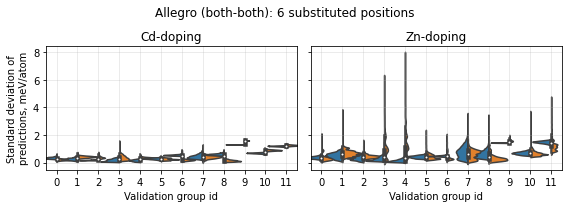

In [12]:
## Using the code below, one can plot the obtained standard deviations of model predictions due to random factors
## within any subset of structures with a certain number of substitutions subst (in the range from 0 to 6)

subst = 6

fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(8,3))
m = re.sub('\n', ' ', models_labels[model])
plt.suptitle(f'{m}: {subst} substituted positions', y=0.95)
for dopant in ['Cd', 'Zn'] :
    for phase in ['black', 'yellow'] :
        su = data[['phase', 'subst', 'dopant'] + [f'val_{i}' for i in range(48)]].copy()
        su = su[(su['phase'] == phase) & (su['subst'] == subst)& (su['dopant'] == dopant)]
        for i in range(12):
            su2 = su[[f'val_{i+12*j}' for j in range(4)]]
            df = (1000*su2.std(axis=1)).to_frame()
            #print(df)
            df['dopant'] = dopant
            df['phase'] = phase
            df['val_id'] = i
            #print(df)
            if (i == 0) & (dopant == 'Cd') & (phase == 'black') :
                res_df = df
            else :
                res_df = pd.concat((res_df, df), axis=0)


for i, dopant in enumerate(['Cd', 'Zn']):
    axs[i].set_title(f'{dopant}-doping')
    sns.violinplot(data=res_df[res_df['dopant']==dopant], x='val_id', y=0, 
                   scale='area', hue='phase', split=True, ax=axs[i], width=1.8)
    axs[i].grid(alpha=0.3)
    axs[i].set_xlabel('Validation group id')
    axs[i].set_ylabel('Standard deviation of\npredictions, meV/atom' if i==0 else None)
    if (i==0) and (j==0) :
        axs[i].legend(loc=2)
    else :
        axs[i].get_legend().remove()

    #axs[i].set_yscale('log')
#plt.ylim((-0.02,2.2))
plt.tight_layout()
plt.show()

### Visual comparison of DFT-derived properties and model predictions for test systems

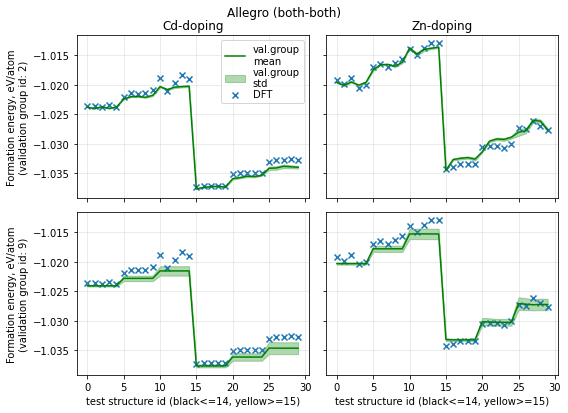

In [13]:
## Using the code below, one can compare visually DFT-derived properties and model predictions for test systems
## val_list correspond to the validation groups of interest [2,9] as in the manuscript

data = inferences['both_both_allegro_non-pr'] ; average = True
data = data[data['inWhichPart'] == 'test']
val_list = [2, 9]

fig, axs = plt.subplots(len(val_list), 2, sharey=True, sharex=True, figsize=(8,3*len(val_list)))
m = re.sub('\n', ' ', models_labels[model])
plt.suptitle(f'{m}', y=0.95)

for i, val in enumerate(val_list) :
    for j, dopant in enumerate(sorted(data['dopant'].unique())) :
        subdata = data[data['dopant'] == dopant]
        if average :
            to_average = np.array([])
            for val_id in [(val + 12 * i) for i in range(4)]:
                d = np.array(subdata[f'val_{val_id}'])
                if len(to_average) == 0 :
                    to_average = d
                    #print(to_average.shape)
                else :
                    to_average = np.vstack((to_average, d))
                    #print(to_average.shape)
                #axs[j].plot(range(len(d)), d, '.-', label=f'{val_id}')
            axs[i,j].plot(range(len(d)), to_average.mean(axis=0), 'g', label='val.group\nmean')
            axs[i,j].fill_between(range(len(d)), to_average.mean(axis=0)-to_average.std(axis=0),
                               to_average.mean(axis=0)+to_average.std(axis=0), color='g', 
                                alpha=0.3, label='val.group\nstd')
        else :
            for val_id in [(validation_group + 12 * i) for i in range(4)]:
                d = np.array(subdata[f'val_{val_id}'])
                axs[i,j].plot(range(len(d)), d, '.-', label=f'{val_id} val.subset')


        axs[i,j].scatter(range(len(d)), subdata['formation_energy_pa_DFT'], label='DFT', marker='x')
        axs[-1,j].set_xlabel('test structure id (black<=14, yellow>=15)')
        axs[i,0].set_ylabel(f'Formation energy, eV/atom\n(validation group id: {val})')
        axs[0,0].legend(labelspacing=0.1)
        axs[i,j].grid(alpha=0.3)
        axs[0,j].set_title(f'{dopant}-doping')
# tag = re.sub('\n', ' ', models_labels[model])
# plt.suptitle(f'{tag}; validation group: {val}')
plt.tight_layout()
plt.show()

### Statistics of validation structures

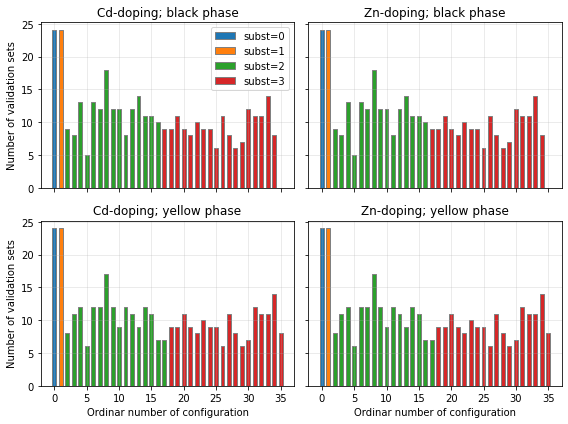

In [14]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(8,6))

for j, dopant in enumerate(sorted(data_with_DFT['dopant'].unique())) :
    for i, phase in enumerate(sorted(data_with_DFT['phase'].unique())) :
        tr_val_data = data_with_DFT[data_with_DFT['inWhichPart'] == 'tr_val']
        subdata = tr_val_data[(tr_val_data['phase'] == phase) & (tr_val_data['dopant'] == dopant)]
        res = subdata[[f'val_{k}_DFT' for k in range(48)]]
        res_subst = subdata['subst']
        shift = 0
        for s in sorted(res_subst.unique()) :
            set_to_plot = res[res_subst == s].sum(axis=1)
            shift += len(set_to_plot)
            axs[i,j].bar(range(shift - len(set_to_plot), shift), set_to_plot, 
                         width=0.6, edgecolor='grey', label=f'subst={s}', align='center')
        axs[i,j].set_title(f'{dopant}-doping; {phase} phase')
        axs[i,j].grid(alpha=0.3)
        if j == 0 :
            axs[i,j].set_ylabel('Number of validation sets')
        if i != 0 :
            axs[i,j].set_xlabel('Ordinar number of configuration')
axs[0,0].legend()
#plt.suptitle('Entries of validation subsets')
plt.tight_layout()
plt.show()

### Maximum force-per-atom distributions

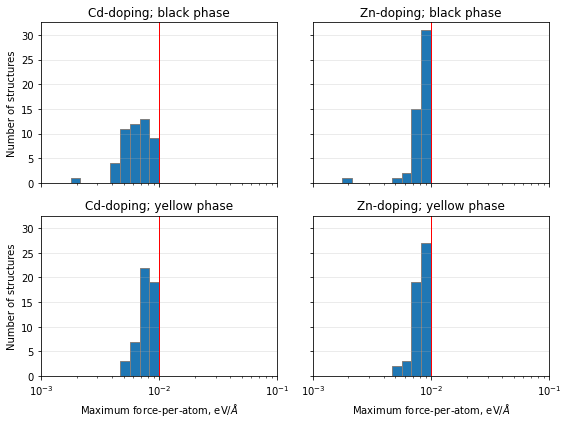

In [15]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(8,6))

for j, dopant in enumerate(sorted(data_with_DFT['dopant'].unique())) :
    for i, phase in enumerate(sorted(data_with_DFT['phase'].unique())) :
        
        subdata = data_with_DFT[(data_with_DFT['phase'] == phase) & (data_with_DFT['dopant'] == dopant)].copy()
        max_forces = np.array(subdata['relaxed_forces_DFT'].map(lambda x: np.sqrt(np.sum((x)**2, axis=1)).max()))
        axs[i,j].hist(max_forces, bins=np.logspace(-3, -1, 25), edgecolor='grey', lw=1)
        #axs[i,j].hist(max_forces,  edgecolor='grey', lw=1)
        axs[i,j].set_title(f'{dopant}-doping; {phase} phase')
        axs[i,j].set_xscale('log')
        #axs[i,j].axvline(x = 3.e-2, c='r', lw=1)
        axs[i,j].axvline(x = 1.e-2, c='r', lw=1)

        axs[i,j].set_xlim((1e-3, 1e-1))
        if i != 0 :
            axs[i,j].set_xlabel('Maximum force-per-atom, eV/$\AA$')
        if j == 0:
            axs[i,j].set_ylabel('Number of structures')
        axs[i,j].grid(alpha=0.3)

#plt.suptitle('Distributions of relaxed structures (maximum forces)')            
plt.tight_layout()
plt.show()

### Relaxed pressure distributions

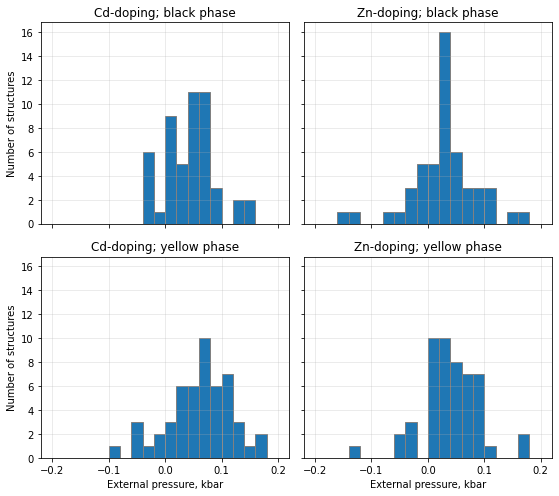

In [16]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(8,7))

for j, dopant in enumerate(sorted(data['dopant'].unique())) :
    for i, phase in enumerate(sorted(data['phase'].unique())) :

        subdata = data_with_DFT[(data_with_DFT['phase'] == phase) & (data_with_DFT['dopant'] == dopant)].copy()
        pressures = subdata['relaxed_pressure_DFT']
        #axs[i,j].hist(pressures, edgecolor='grey', lw=1)
        axs[i,j].hist(pressures, bins=np.linspace(-0.2, 0.2, 21), edgecolor='grey', lw=1)
        axs[i,j].set_title(f'{dopant}-doping; {phase} phase')
        if i != 0 :
            axs[i,j].set_xlabel('External pressure, kbar')
        if j == 0:
            axs[i,j].set_ylabel('Number of structures')
        axs[i,j].grid(alpha=0.3)

#plt.suptitle('Distributions of relaxed structures (external pressures)')            
plt.tight_layout()
plt.show()